In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

In [5]:
from sklearn.metrics import mean_squared_error, classification_report, precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

In [6]:
df = pd.read_csv('bank+marketing/bank-additional/bank-additional.csv', delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [7]:
lg_df = pd.read_csv('bank+marketing/bank-additional/bank-additional-full.csv', delimiter=';')

   # Input variables:
   ### bank client data:
   - 1 - age (numeric)
   - 2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   - 3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   - 4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   - 5 - default: has credit in default? (categorical: "no","yes","unknown")
   - 6 - housing: has housing loan? (categorical: "no","yes","unknown")
   - 7 - loan: has personal loan? (categorical: "no","yes","unknown")
   ### related with the last contact of the current campaign:
   - 8 - contact: contact communication type (categorical: "cellular","telephone") 
   - 9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  - 10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  - 11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   ### other attributes:
  - 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  - 14 - previous: number of contacts performed before this campaign and for this client (numeric)
  - 15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
   ### social and economic context attributes
  - 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  - 17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  - 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  - 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  - 20 - nr.employed: number of employees - quarterly indicator (numeric)

### Target
y is the target that denotes if a client subscribed to a term deposit or not

In [10]:
df.y.value_counts()

y
no     3668
yes     451
Name: count, dtype: int64

Text(0.5, 0, 'Class')

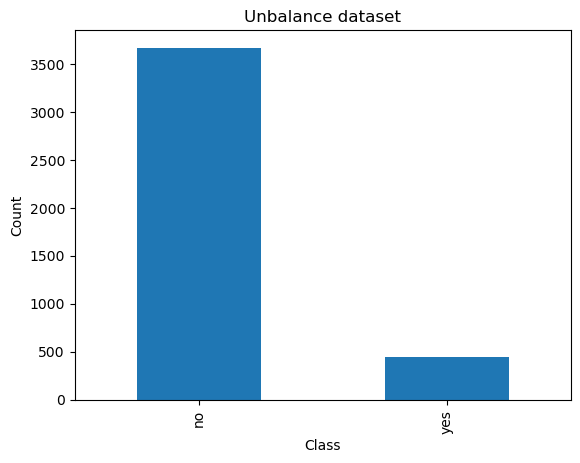

In [94]:
# we have a very unbalanced data
df.y.value_counts().plot(kind='bar')
plt.title('Unbalance dataset')
plt.ylabel('Count')
plt.xlabel('Class')

### Looking for relationships between the columns and the target. 

Text(0.5, 0, 'Job')

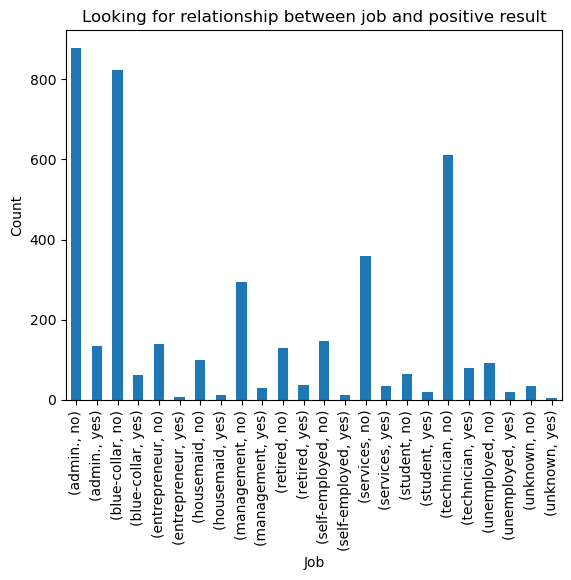

In [98]:
# job vs. target
newdf = df[['job','y']]
newdf.groupby('job')['y'].value_counts().plot(kind='bar')
plt.title('Looking for relationship between job and positive result')
plt.ylabel('Count')
plt.xlabel('Job')

Text(0.5, 0, 'Status')

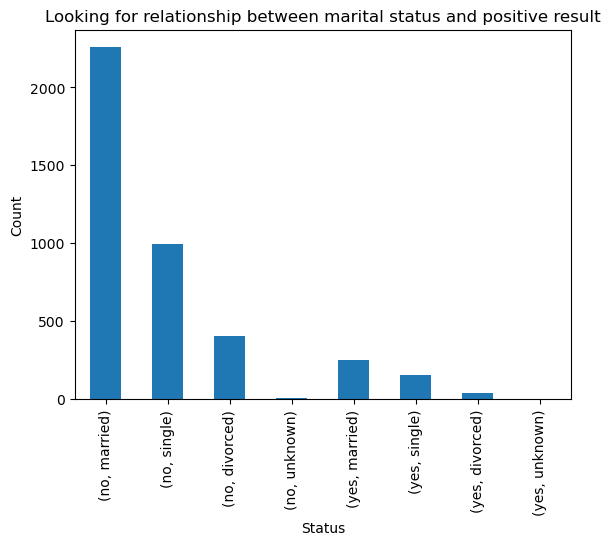

In [100]:
# marital status vs. target
newdf = df.groupby('y')[['marital','y']]
y = newdf.value_counts()
y.plot(kind='bar')
plt.title('Looking for relationship between marital status and positive result')
plt.ylabel('Count')
plt.xlabel('Status')

## Conclusion:
#### There seem to be no direct relationship between any columns to the target

# Prepping the data

I will drop these columns
- job column because I think education and job are somewhat related
- month
- day_of_week
- pdays - too many values at 999.0 (not contacted). I don't think this will provide classification help
- default - There are 803 unknowns.

In [17]:
def drop_columns(df):
    return df.drop(columns={'job', 'month', 'day_of_week', 'pdays', 'default'})

def drop_unknowns(df):
    df.drop(df.index[df['loan'] == 'unknown'], inplace = True)
    df.drop(df.index[df['housing'] == 'unknown'], inplace = True)
    return df

def oh_encode(df):
    toEncode = ['housing','loan','contact']
    #toEncode = cols
    encoder = OneHotEncoder(drop='first',sparse_output=False)  #need the sparce_output = False. otherwise the encoder returned in compressed and causes issues
    one_hot_encoded = encoder.fit_transform(df[toEncode])

    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(toEncode))
    return (pd.concat([df, one_hot_df], axis=1).drop(columns=toEncode))

def oh_encode_noDrop(df):
    toEncode = ['poutcome','marital','education','poutcome']
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(df[toEncode])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(toEncode))
    return (pd.concat([df, one_hot_df], axis=1).drop(columns=toEncode))
    
def label_encode(df):
    le = LabelEncoder()
    df['y_encoded'] = le.fit_transform(df.y)
    df.drop(df.index[df['y_encoded'] == 2], inplace = True)
    df.dropna(axis=0, inplace=True)
    return df


In [18]:
piped_df = drop_columns(df).pipe(drop_unknowns).pipe(oh_encode).pipe(oh_encode_noDrop).pipe(label_encode)

In [19]:
piped_df.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,education_illiterate,education_professional.course,education_university.degree,education_unknown,education_nan,poutcome_failure,poutcome_nonexistent,poutcome_success,poutcome_nan,y_encoded
0,30.0,487.0,2.0,0.0,-1.8,92.893,-46.2,1.313,5099.1,no,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,39.0,346.0,4.0,0.0,1.1,93.994,-36.4,4.855,5191.0,no,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,25.0,227.0,1.0,0.0,1.4,94.465,-41.8,4.962,5228.1,no,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,47.0,58.0,1.0,0.0,-0.1,93.200,-42.0,4.191,5195.8,no,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5,32.0,128.0,3.0,2.0,-1.1,94.199,-37.5,0.884,4963.6,no,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [20]:
# cols = ['nr.employed','cons.price.idx','cons.conf.idx','euribor3m','duration']
# cols_encoded = ['nr.employed_scaled','cons.price.idx_scaled','cons.conf.idx_scaled','euribor3m_scaled','duration_scaled']
# scaler = StandardScaler()
# transformed = scaler.fit_transform(piped_df[cols])
# scaled = pd.DataFrame(transformed,columns=cols_encoded)
# scaled = pd.concat([piped_df, scaled], axis=1).drop(columns=cols)
# scaled.dropna()
# piped_df = scaled

## Modelling

In [22]:
# Split the data into training and testing sets
X = piped_df.drop(columns=['y','y_encoded'])
y = piped_df['y_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
params = [{'penalty':['none', 'elasticnet', 'l1', 'l2']},
          {'C':[0.01, 0.01, 0.1, 1, 10, 100]}]
grid_search_lgr = GridSearchCV(estimator = LogisticRegression(),  
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search_lgr.fit(X_train, y_train)

print(grid_search_lgr.best_estimator_)

#grid_search_lgr.cv_results_['mean_fit_time'].min()
#print(grid_search_lgr.cv_results_['mean_fit_time'].max())
average_fit_time_log_reg = grid_search_lgr.cv_results_['mean_fit_time'][grid_search_lgr.best_index_]
train_score_log_reg = grid_search_lgr.score(X_train, y_train)
test_score_log_reg = grid_search_lgr.score(X_test, y_test)

LogisticRegression(C=100)


In [24]:
params = {'n_neighbors': list(range(1, 31))}

grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
grid_knn.fit(X_train, y_train)

print(grid_knn.best_estimator_)

average_fit_time_knn = grid_knn.cv_results_['mean_fit_time'][grid_knn.best_index_]
train_score_knn = grid_knn.score(X_train, y_train)
test_score_knn = grid_knn.score(X_test, y_test)

KNeighborsClassifier(n_neighbors=28)


In [25]:
params = { 'criterion':['gini','entropy'],
          'max_depth': np.arange(3, 15)}

grid_tree = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params)
grid_tree.fit(X_train, y_train)
grid_score = grid_tree.score(X_train, y_train)

print(grid_tree.best_estimator_)

average_fit_time_dt = grid_tree.cv_results_['mean_fit_time'][grid_tree.best_index_]
train_score_dt = grid_tree.score(X_train, y_train)
test_score_dt = grid_tree.score(X_test, y_test)

DecisionTreeClassifier(max_depth=4)


In [26]:
params = {'kernel': ['rbf', 'linear', 'sigmoid'],
         'gamma': [0.1, 1.0, 10.0, 100.0]}

grid_svc = GridSearchCV(estimator=SVC(),param_grid=params)
grid_svc.fit(X_train, y_train)
grid_score = grid_svc.score(X_train, y_train)

print(grid_svc.best_estimator_)

average_fit_time_svc = grid_svc.cv_results_['mean_fit_time'][grid_svc.best_index_]
train_score_svc = grid_svc.score(X_train, y_train)
test_score_svc = grid_svc.score(X_test, y_test)

SVC(gamma=0.1, kernel='linear')


In [27]:
comparison_df = pd.DataFrame(columns=['model', 'train score', 'test score', 'average fit time'])

comparison_df = pd.concat([comparison_df, pd.DataFrame([{
    'model': 'KNN',
    'train score': train_score_knn,
    'test score': test_score_knn,
    'average fit time': average_fit_time_knn
}])], ignore_index=True)

comparison_df = pd.concat([comparison_df, pd.DataFrame([{
    'model': 'Logistic Regression',
    'train score': train_score_log_reg,
    'test score': test_score_log_reg,
    'average fit time': average_fit_time_log_reg
}])], ignore_index=True)

comparison_df = pd.concat([comparison_df, pd.DataFrame([{
    'model': 'Decision Tree',
    'train score': train_score_dt,
    'test score': test_score_dt,
    'average fit time': average_fit_time_dt
}])], ignore_index=True)

comparison_df = pd.concat([comparison_df, pd.DataFrame([{
    'model': 'SVC',
    'train score': train_score_svc,
    'test score': test_score_svc,
    'average fit time': average_fit_time_svc
}])], ignore_index=True)

comparison_df.set_index('model', inplace=True)
comparison_df

,train score,test score,average fit time
model,,,
KNN,0.913118,0.899898,0.000944
Logistic Regression,0.914821,0.905005,0.023678
Decision Tree,0.924702,0.895812,0.003461
SVC,0.909710,0.905005,1.149165


<Figure size 1000x500 with 0 Axes>

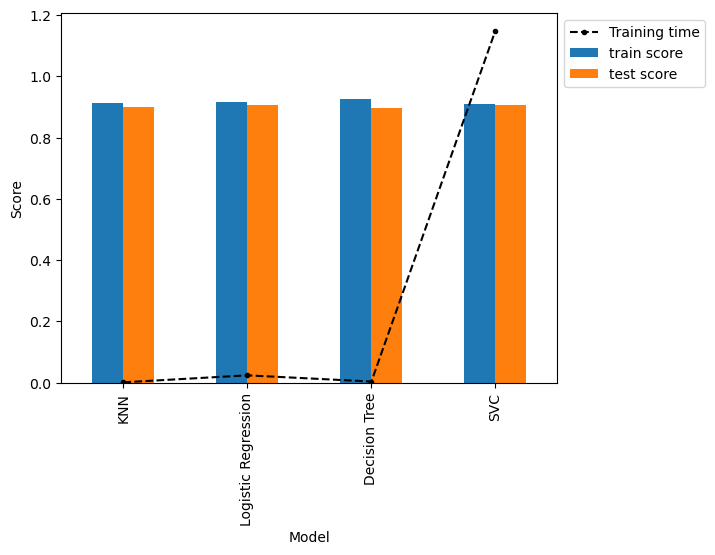

In [28]:
plt.figure(figsize=(10,5))
comparison_df[['train score','test score']].plot(kind='bar')
plt.plot(comparison_df['average fit time'],'k.--',label='Training time')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Considering KNN Classifier has a lower training time but similar train/test score other classifiers, let's process further using KNN

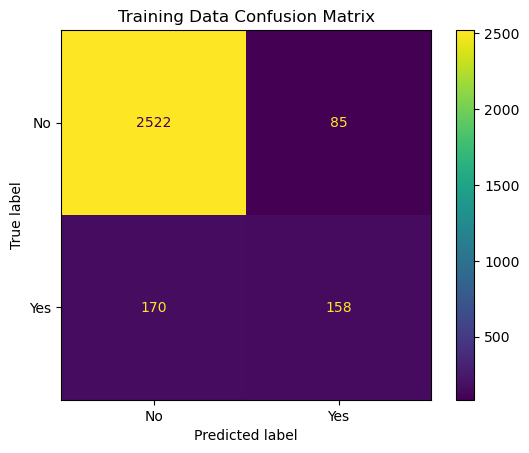

[(0, 2607), (1, 328)]


In [30]:
knn = KNeighborsClassifier(n_neighbors=28).fit(X_train, y_train)
knn_preds = knn.predict(X_train)
knn_confusion_mat = confusion_matrix(y_train, knn_preds)
knn_dist = ConfusionMatrixDisplay(confusion_matrix = knn_confusion_mat, display_labels = ['No', 'Yes'])
knn_dist.plot()
plt.title('Training Data Confusion Matrix')
plt.show()
print(sorted(Counter(y_train).items()))

In [31]:
precision_score(y_train, knn_preds, pos_label=1)

0.6502057613168725

### Since we know the classes are unbalanced, let's see if oversampling to balance the training data helps at all

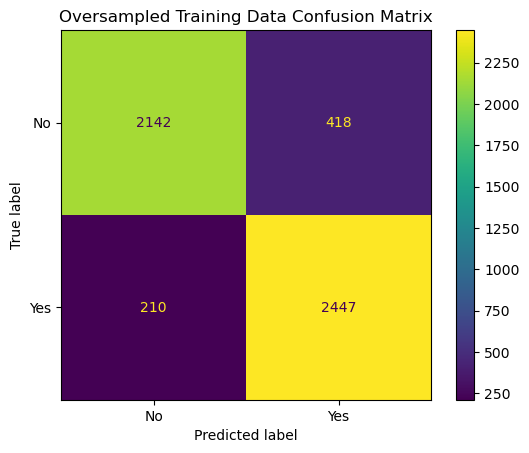

[(0, 2560), (1, 2657)]


In [33]:
X_tmp = piped_df.drop(columns=['y','y_encoded'])
y_tmp = piped_df['y_encoded']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tmp, y_tmp)

X_train_resamp, X_test_resamp, y_train_resamp, y_test_resamp = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

knn_resamp = KNeighborsClassifier(n_neighbors=28).fit(X_train_resamp, y_train_resamp)
preds_resamp = knn_resamp.predict(X_train_resamp)
knn_confusion_mat_resamp = confusion_matrix(y_train_resamp, preds_resamp)
dist_resamp = ConfusionMatrixDisplay(confusion_matrix = knn_confusion_mat_resamp, display_labels = ['No', 'Yes'])
dist_resamp.plot()
plt.title('Oversampled Training Data Confusion Matrix')
plt.show()

print(sorted(Counter(y_train_resamp).items()))

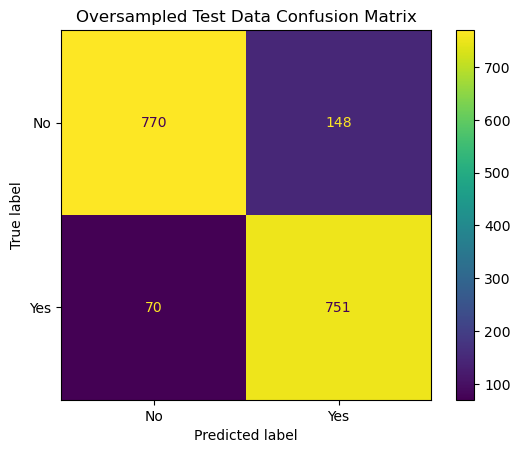

In [34]:
preds_resamp_test = knn_resamp.predict(X_test_resamp)
knn_confusion_mat_resamp_test = confusion_matrix(y_test_resamp, preds_resamp_test)
dist_resamp_test = ConfusionMatrixDisplay(confusion_matrix = knn_confusion_mat_resamp_test, display_labels = ['No', 'Yes'])
dist_resamp_test.plot()
plt.title('Oversampled Test Data Confusion Matrix')
plt.show()

### Run the large dataset through the cleaning process

In [36]:
piped_lg_df = drop_columns(lg_df).pipe(drop_unknowns).pipe(oh_encode).pipe(oh_encode_noDrop).pipe(label_encode)

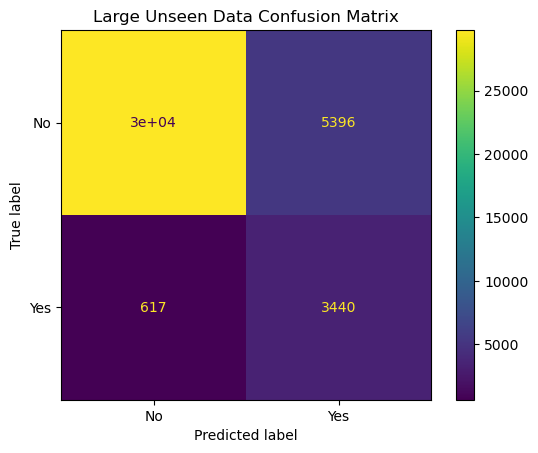

In [37]:
X_large = piped_lg_df.drop(columns={'y','y_encoded'})
y_large = piped_lg_df.y_encoded

preds_large = knn_resamp.predict(X_large)
large_confusion_mat = confusion_matrix(y_large, preds_large)
dist = ConfusionMatrixDisplay(confusion_matrix = large_confusion_mat, display_labels = ['No', 'Yes'])
dist.plot()
plt.title('Large Unseen Data Confusion Matrix')
plt.show()

#3e+04 = 15876 ??

In [38]:
precision_score(y_large, preds_large,pos_label=1)

0.3893164327750113

### Oversampling might have helped test and train data but wasn't as effective with unseen data. We might have captured more true positives but we also have an even larger false positives. 
### Depending on what we're trying to achieve, and if we're ok with false positives as long as we capture more true positives, we might go with oversample trained model

### For now let's stick to normal dataset that hasn't been oversampled and KNN Classifier

In [41]:
knn_preds_large = knn.predict(X_large)

In [42]:
print(classification_report(y_large, knn_preds_large))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     35182
           1       0.62      0.37      0.47      4057

    accuracy                           0.91     39239
   macro avg       0.78      0.67      0.71     39239
weighted avg       0.90      0.91      0.90     39239



In [43]:
svc = SVC(gamma=0.1, kernel='linear').fit(X_train, y_train)
svc_preds_large = svc.predict(X_large)

print(classification_report(y_large, svc_preds_large))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     35182
           1       0.63      0.26      0.37      4057

    accuracy                           0.91     39239
   macro avg       0.78      0.62      0.66     39239
weighted avg       0.89      0.91      0.89     39239



### precision on the unseen data with model trained on original dataset is better than with model trained on oversampled dataset. 
### I think precision is the right metric to consider becuase we are looking to identify a 1 for the target value as they are the ones who we think would to acceptable towards "term-deposit"
### Between the SVC and Logistic, precision in SVC was a 1% higher but the overall F1 was much lower. F1 score was lower by 10%
### I think at this point, KNN Classifier is the better model to use.

In [45]:
knn_preds = knn.predict_proba(X_train)
knn_preds_df = pd.DataFrame(knn_preds)
knn_preds_df

,0,1
0,1.000000,0.000000
1,1.000000,0.000000
2,0.964286,0.035714
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
2930,0.428571,0.571429
2931,1.000000,0.000000
2932,1.000000,0.000000
2933,0.607143,0.392857


In [46]:
precision, recall, thresholds = precision_recall_curve(y_train, knn_preds[:,1], pos_label=1)

precision_recall_data = pd.DataFrame({'threshold': thresholds, 
                                      'precision': precision[1:], 
                                      'recall': recall[1:]})
precision_recall_data.head()

,threshold,precision,recall
0,0.000000,0.268193,1.000000
1,0.035714,0.357306,0.954268
2,0.071429,0.404762,0.932927
3,0.107143,0.434911,0.896341
4,0.142857,0.476898,0.881098


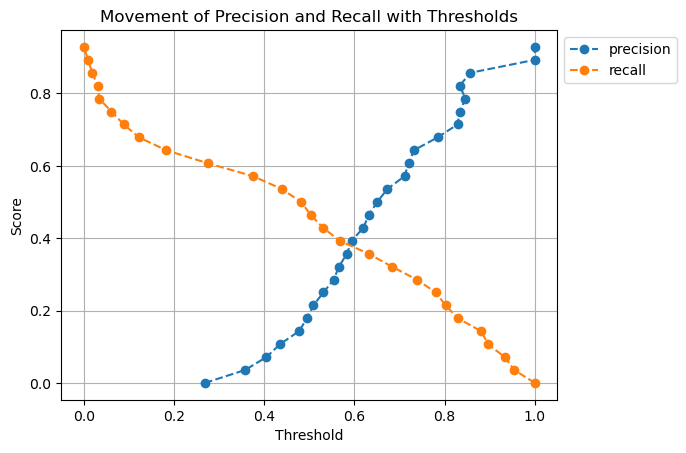

In [47]:
plt.plot(precision_recall_data.precision, precision_recall_data.threshold, '--o', label = 'precision')
plt.plot(precision_recall_data.recall, precision_recall_data.threshold, '--o', label = 'recall')
plt.title('Movement of Precision and Recall with Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))

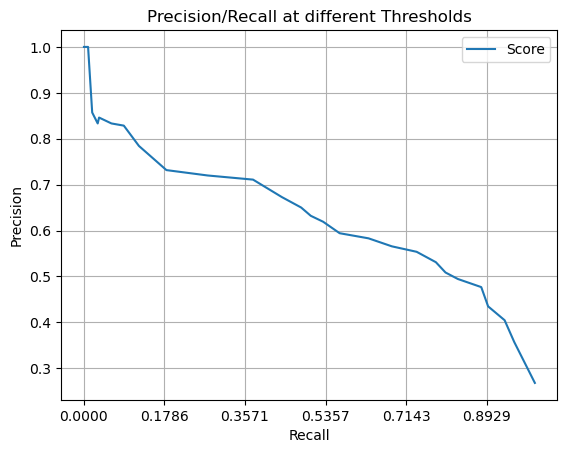

In [48]:
plt.plot(precision_recall_data.recall, precision_recall_data.precision, label = 'Score')
plt.title('Precision/Recall at different Thresholds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xticks(thresholds[::5]) #take the thresholds list then display every other 5th point as the xtick
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))

### Here we see, as the Recall increases, Precision decreases. At this point the subject matter expert can decide what threshold to consider when classifying the data. The subject matter expert would take into consideration the right recall/precision compromise.

## Let's look at the ROC (Receiver Operator Curve)
### The subject matter expert can look at the ROC curve to see what is a good percentage of acceptable false positives versus true positive. If this was a medical report classifier, maybe I am willing to take lots of false positive so that all true positives are captured. But considering this is a bank account classifier, I might want to consider a different compromise.
https://www.youtube.com/watch?v=4jRBRDbJemM&list=PLsFEha8AuPfAFz80BsOC1M2OoVOzAPPeO&index=4

False Positive Rates:  [0.         0.         0.00038358 0.00076717 0.00076717]
True Positive Rates:  [0.         0.00914634 0.01829268 0.0304878  0.03353659]


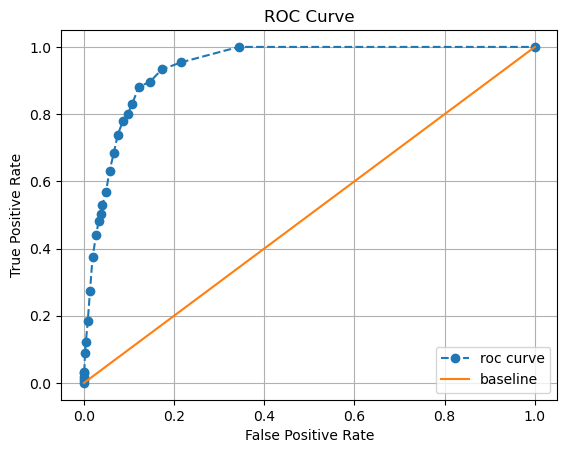

In [51]:
fpr, tpr, thresh_rocs = '', '', ''

fpr, tpr, thresh_rocs = roc_curve(y_train, knn_preds[:, 1], pos_label=1)

print('False Positive Rates: ', fpr[:5])
print('True Positive Rates: ', tpr[:5])
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

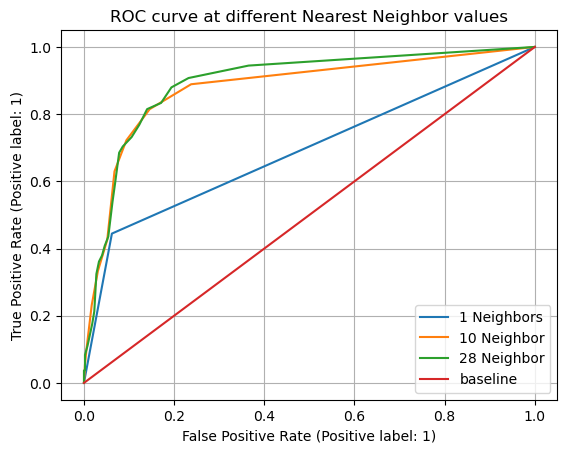

In [52]:
knn_1_pipe = Pipeline([('knn', KNeighborsClassifier(n_neighbors = 1))])
knn_1_pipe.fit(X_train, y_train)

knn_10_pipe = Pipeline([('knn', KNeighborsClassifier(n_neighbors = 10))])
knn_10_pipe.fit(X_train, y_train)

knn_28_pipe = Pipeline([('knn', KNeighborsClassifier(n_neighbors = 28))])
knn_28_pipe.fit(X_train, y_train)

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(knn_1_pipe, X_test, y_test, pos_label = 1, ax = ax, label = '1 Neighbors')
RocCurveDisplay.from_estimator(knn_10_pipe, X_test, y_test, ax = ax, label = '10 Neighbor')
RocCurveDisplay.from_estimator(knn_28_pipe, X_test, y_test, ax = ax, label = '28 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('ROC curve at different Nearest Neighbor values')
plt.legend();

### From looking at the ROC curve for models trained with different Neighbor values, there is only a slight difference between models using 10 Neighbors versus 28 Neighbors (GridSearchCV recommended value).